[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/openvinotoolkit/openvino_tensorflow/blob/master/examples/notebooks/OpenVINO_TensorFlow_Efficientdet_FasterRCNN_SSD_example.ipynb)

# Object Detection with [OpenVINO™ integration with TensorFlow](https://github.com/openvinotoolkit/openvino_tensorflow)

[OpenVINO™ integration with TensorFlow](https://github.com/openvinotoolkit/openvino_tensorflow) is designed for TensorFlow developers who want to get started with [OpenVINO™](https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/overview.html) in their inferencing applications. This product delivers OpenVINO™ inline optimizations, which enhance inferencing performance of popular deep learning models with minimal code changes and without any accuracy drop. OpenVINO™ integration with TensorFlow accelerates inference across many AI models on a variety of Intel® silicon such as:

 - Intel® CPUs
 - Intel® integrated GPUs
 - Intel® Movidius™ Vision Processing Units - referred to as VPU

## About this sample

This sample walks you through a demo of performing object detection on TensorFlow using the most popular object detection architectures on [TensorFlow Hub](https://www.tensorflow.org/hub). In the end, we will run inference on both Native TensorFlow and **OpenVINO integration with TensorFlow** backends, and demonstrate the performance benefits when **OpenVINO integration with TensorFlow** is enabled.
 

Firstly, we download all the models and input images. Next, we load them to be inferred on TensorFlow. After inference, the output detections are visualized. 

## Prerequisites

**Note**: All the prerequisites are available in this notebook and a procedure to fetch them is also explained.

 - Models: Efficientdet_d6_coco17_tpu-32, Faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8, and SSD_resnet50_v1_fpn_640x640_coco17_tpu-8
 - Images: Test image used from the tensorflow/models GitHub repo. You can also specify your own image as test image in [Set models and images](#Set-models-and-images) section.
 - TensorFlow: We use the TensorFlow version v2.9.2 from PyPi. Note that this version of TF is a dependency of **OpenVINO integration with TensorFlow** v2.2.0.

## About the models 


[EfficientDet_d6](https://tfhub.dev/tensorflow/efficientdet/d6/1) is trained on the COCO 2017 dataset. This model is a combination of SSD with EfficientNet-b6 + BiFPN feature extractor, shared box predictor, and focal loss.

[Faster R-CNN with Resnet-152 V1](https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1) is also trained on the COCO 2017 dataset  with training images scaled to 1024x1024.

[Retinanet (SSD with Resnet 50 v1)](https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1) is also trained on the COCO 2017 dataset with training images scaled to 640x640.

For all three models, the input is a three-channel tensor of type tf.uint8 and shape [1, height, width, 3]. The output dictionary contains:

- num_detections: a tf.int tensor with only one value, the number of detections [N].
- detection_boxes: a tf.float32 tensor of shape [N, 4] containing bounding box coordinates in the following order: [ymin, xmin, ymax, xmax].
- detection_classes: a tf.int tensor of shape [N] containing detection class index from the label file.
- detection_scores: a tf.float32 tensor of shape [N] containing detection scores.
- raw_detection_boxes: a tf.float32 tensor of shape [1, M, 4] containing decoded detection boxes without Non-Max suppression. M is the number of raw detections.
- raw_detection_scores: a tf.float32 tensor of shape [1, M, 90] and contains class score logits for raw detection boxes. M is the number of raw detections.
- detection_anchor_indices: a tf.float32 tensor of shape [N] and contains the anchor indices of the detections after NMS.
- detection_multiclass_scores: a tf.float32 tensor of shape [1, N, 90] and contains class score distribution (including background) for detection boxes in the image including background class.
      

## Getting Started 

In this section, we install TensorFlow, OpenVINO integration with TensorFlow, other necessary python packages, and import them.

First, let's make sure we're running this notebook on a supported Intel CPU

In [14]:
# Note: This works only on Linux! 
!lscpu | grep name

Model name:          Intel(R) Core(TM) i9-9960X CPU @ 3.10GHz


### Install [OpenVINO™ integration with TensorFlow](https://github.com/openvinotoolkit/openvino_tensorflow) 

In [ ]:
import os
root_path = os.getcwd()

# Enable this variable for runtime inference optimizations
os.environ["OPENVINO_TF_CONVERT_VARIABLES_TO_CONSTANTS"] = "1"

!python3 -m pip install --upgrade pip
!python3 -m pip install opencv-python-headless matplotlib scipy tensorflow_hub

# Install TensorFlow (v2.9.2) and OpenVINO integration with TensorFlow (v2.2.0)
!python3 -m pip install --force-reinstall tensorflow-cpu==2.9.2
!python3 -m pip install --force-reinstall openvino-tensorflow==2.2.0

### Import required packages 

In [2]:
import io
import cv2
import time
import pathlib
import colorsys
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub
import openvino_tensorflow as ovtf

tf.get_logger().setLevel('ERROR')

### Clone TensorFlow models : GitHub Repository
Clone Tensorflow/models github repository to be used in the later sections.

In [3]:
!git clone --depth 1 https://github.com/tensorflow/models.git #This repo is cloned to use in the later context

fatal: destination path 'models' already exists and is not an empty directory.


### Get Labels
Here we open and read a label file for the MSCOCO 80 classes dataset

In [4]:
# Download mscoco label map
!wget "https://raw.githubusercontent.com/openvinotoolkit/openvino_tensorflow/master/examples/notebooks/mscoco_label_map.txt"

labels = {}
with open("mscoco_label_map.txt") as f:
    for label_map in f.readlines():
        id = int(label_map.strip().split(":")[0])
        label_name = label_map.strip().split(":")[1]
        labels[id] = label_name
print(labels, len(labels))

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

## Get Models and Images

In this section, we focus on setting up the models and inputs.

###  Set models and images
For the model:
Create a nested 'models' dictionary which contains model's URL [which is a tar file] as 'model_url', once the model is downloaded and untar we save the models in location as 'model_dir', save model's size as 'model_size' to be used in models IR file generation and the generated IR files are saved in a directory as 'model_ir' required for Native OpenVINO inference.

For the test image:
We are using input images available from the tensorflow/models github repo as an example. **Note**: You can also specify any image that you wish to test the models on by adding the name and location/URL of the image into the below 'images' dictionary.

In [5]:
# A nested dictionary of with above mentioned object detection models is created to be used in later sections

models = {
    "efficientdet_d6_coco17_tpu-32" : {'model_url' : 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d6_coco17_tpu-32.tar.gz','model_dir' : 'downloaded_models/efficientdet_d6_coco17_tpu-32/saved_model','model_size' : '512','model_ir' : 'ir_files/efficientdet_d6_coco17_tpu-32/saved_model.xml'},
    "faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8" : {'model_url' : 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz','model_dir' : 'downloaded_models/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8/saved_model', 'model_size' : '640','model_ir' : 'ir_files/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8/saved_model.xml'},
    "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8" : {'model_url' : 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz', 'model_dir' : 'downloaded_models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model', 'model_size' : '640','model_ir' : 'ir_files/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model.xml'}

}

images = {
    'Beach' : 'models/research/object_detection/test_images/image2.jpg',
    'Dogs' : 'models/research/object_detection/test_images/image1.jpg'
}

input_image = images["Beach"] #You can select the test image added in 'images' dictionary here. Like: images['your_test_image']

## Define input processing methods

In this section, we define methods useful for image and model loading, which give the right input formats to be used in inferencing.

In [6]:
# Helper to fetch model details
def get_model_details(model_name):
    if model_name in models:
        return models[model_name]

# Helper to fetch image details
def get_image(image_name):
    if image_name in images:
        return images[image_name]
        
# We are loading the selected model using 'tensorflow_hub.load'.
def load_model(model_name,input_model):
  print(f"Loading {model_name}...")
  model = hub.load(input_model)
  print(f"{model_name} loaded successfully!")
  return model

# We use the image URL or direct image location to read and get the input tensor
def load_image(input_image):
  print("Loading input image...")  
  image = None
  if(input_image.startswith('https')):
    response = urlopen(input_image)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image_data = Image.open(image_data)
  else:
    image_data = cv2.imread(input_image)

  (img_width, img_height) = image_data.shape[1],image_data.shape[0]
  return np.array([image_data], dtype = np.uint8), img_height, img_width

### Download models
Create a 'downloaded_models' directory to download and save the models and untar them to use while model inferencing. Also, create 'output_images' directory to save the output images after model inferencing into that.

In [7]:
if os.getcwd() == root_path and not os.path.exists("downloaded_models"):
    path = os.path.join(os.getcwd(),"downloaded_models")
    os.mkdir(path)
if os.getcwd() == root_path and not os.path.exists("output_images"):
    path = os.path.join(os.getcwd(),"output_images")
    os.mkdir(path)
    
if not os.getcwd() == root_path+"/downloaded_models":
    os.chdir("downloaded_models") #changing to download_models directory
if not os.listdir(os.getcwd()):
    for model_name in models:
        model_url = get_model_details(model_name)["model_url"]
        !wget "$model_url"
    for model_tar in os.listdir(os.getcwd()):
        !tar -zxvf "$model_tar"
os.chdir(root_path)

## Define output processing methods

In this section, we define methods useful post model inferencing to visualize the outputs.

In [8]:
# Generate colors for drawing the bounding boxes detected.
def get_colors(class_names):
    # Generate colors for drawing bounding boxes.
    hsv_tuples = [
        (x / len(class_names), 1., 1.) for x in range(len(class_names))
    ]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.
    return colors

# Define a method to get coordinate details of the detected bounding boxes to be drawn on the output image.
def get_coordinates(box, img_height, img_width):
    return [int(box[0]*img_height),int(box[1]*img_width), int(box[2]*img_height), int(box[3]*img_width)]

# Define a method to add labels for the detected bounding boxes.
def add_label(image, text, color, coords):
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 1.
    (text_width, text_height) = cv2.getTextSize(
        text, font, fontScale=font_scale, thickness=1)[0]

    padding = 5
    rect_height = text_height + padding * 2
    rect_width = text_width + padding * 2

    (x, y) = coords

    cv2.rectangle(image, (x, y), (x + rect_width, y - rect_height), color,
                  cv2.FILLED)
    cv2.putText(
        image,
        text, (x + padding, y - text_height + padding),
        font,
        fontScale=font_scale,
        color=(255, 255, 255),
        lineType=cv2.LINE_AA)

    return image

# Define a method for drawing the obtained bounding boxes.
def draw_boxes(image,
               boxes,
               classes,
               scores,
               class_names,
               colors,
               show_score=True):
    if classes is None or len(classes) == 0:
        return image

    for box, cls, score in zip(boxes, classes, scores):
        ymin, xmin, ymax, xmax = box
        
        class_name = class_names[cls]
        if show_score:
            label = '{} {:.2f}'.format(class_name, score)
        else:
            label = '{}'.format(class_name)

        # if no color info, use black(0,0,0)
        if colors == None:
            color = (0, 0, 0)
        else:
            color = colors[cls]
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1, cv2.LINE_AA)
        image = add_label(image, label, color, (xmin, ymin))

    return image

# Define a method to visualize the predictions obtained through inferencing.
def visualize_ouput(model_name,predictions,img_height,img_width,isovtf):
    colors = get_colors(labels)
    class_ids = predictions["detection_classes"][0].numpy().astype("int")
    scores = predictions["detection_scores"][0].numpy()
    num_detections = predictions["num_detections"][0].numpy().astype("int")
    detection_boxes = predictions["detection_boxes"][0].numpy()
    conf_threshold = 0.4 # You can try increase/decrease threshold to see the output changes
    boxes = []
    confidence_scores = []
    classes = []
    for detection_index in range(num_detections):
        if scores[detection_index]<conf_threshold:
            continue
        else:
            confidence_scores.append(scores[detection_index])
            classes.append(class_ids[detection_index])
            boxes.append(get_coordinates(detection_boxes[detection_index], img_height, img_width))
            
    img_bbox = draw_boxes(cv2.imread(input_image), boxes, classes, scores,
                        labels, colors)
    if isovtf:
        output_image_name = model_name + "_OVTF" + "_detected_output"
    else:
        output_image_name = model_name + "_TF" + "_detected_output"
    cv2.imwrite("output_images/" + output_image_name + ".png", img_bbox)

## Define inference

In [9]:
def run_inference(model,image):
    """Run inference to capture output and performance results"""
    elapsed = 0.0
    total_time = 0.0
    num_iterations = 20 #You can increase/decrease number of iterations and see output changes

    print("Running 5 warmup inference iterations...")
    # run 5 warmup iterations
    for i in range(5):
        predictions = model(image)
    
    print("Running %d inference iterations..."%num_iterations)
    # capature the average performance results
    for i in range(num_iterations):
        start = time.time()
        model(image)
        elapsed = time.time() - start
        total_time += elapsed
    
    # calculate average inference time over number of iterations in milliseconds
    # and round the number to 2 decimal points
    average_time = round((total_time/num_iterations)*1000,2)
                
    return predictions, average_time

## Let's infer

### Run with OpenVINO™ integration with TensorFlow enabled
Enable OpenVINO TensorFlow with the openvino_tensorflow.enable() API and set backend name to run on OpenVINO runtime.

In [10]:
ovtf.enable() # Enable OpenVINO integration with TensorFlow

backend_name = "CPU" # Define the backend to be enabled

print('Available Backends:') # Print list of available backends
backends_list = ovtf.list_backends() # To determine available backends on your system, 'list_backends' API is used
for backend in backends_list:
    print(f"\t{backend}")

ovtf.set_backend(backend_name) # Set the backend
print(f"OpenVINO integration with TensorFlow is enabled and device {backend_name} is set as backend.")

image, img_height, img_width = load_image(input_image) # Loading the input image

# Disable TF Logging
os.environ["TF_CPP_MAX_VLOG_LEVEL"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Record average latency of each model in this dict
ovtf_latency = {}

# Running all the models iteratively
for model_name in models:
    input_model = get_model_details(model_name)["model_dir"] # Get model location
    model = load_model(model_name,input_model) # Loading the model
    predictions,average_time = run_inference(model,image) # Running inference
    visualize_ouput(model_name, predictions, img_height, img_width, 1) # Visualizing the output. Here '1' is set to indicate model run on OVTF
    ovtf_latency[model_name] = int(average_time)
    print(f"Inference Successfully completed on OpenVINO TensorFlow..! {model_name} model run on {backend_name} in {average_time} ms\n"),
    print(f"-----------------------")

Available Backends:
	CPU
	MYRIAD
OpenVINO TensorFlow is enabled and device CPU is set as backend.
Loading input image...
Loading efficientdet_d6_coco17_tpu-32...
efficientdet_d6_coco17_tpu-32 loaded successfully!
Running 5 warmup inference iterations...
2022-09-23 18:08:03.58084: OVTF Summary -> 3236 out of 6895 nodes in the graph (46%) are now running with OpenVINO™ backend
Running 20 inference iterations...
Inference Successfully completed on OpenVINO TensorFlow..! efficientdet_d6_coco17_tpu-32 model run on CPU in 1674.12 ms

-----------------------
Loading faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8...
faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8 loaded successfully!
Running 5 warmup inference iterations...
2022-09-23 18:09:14.817189: OVTF Summary -> 1903 out of 4282 nodes in the graph (44%) are now running with OpenVINO™ backend
Running 20 inference iterations...
Inference Successfully completed on OpenVINO TensorFlow..! faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8 model 

### Run with native TensorFlow
Disable OpenVINO integration with TensorFlow with the openvino_tensorflow.disable() API to run on native TensorFlow runtime.

In [11]:
ovtf.disable() # Disable OpenVINO integration with TensorFlow
print("OpenVINO integration with TensorFlow is disabled\n")

backend_name = "CPU" # Define the backend

# Record average latency of each model in this dict
tf_latency = {}

image, img_height, img_width = load_image(input_image) # Loading the input_image
for model_name in models:
    input_model = get_model_details(model_name)["model_dir"] # Get model location
    model = load_model(model_name,input_model) # Loading the model
    predictions,average_time = run_inference(model,image) # Running inference
    visualize_ouput(model_name, predictions, img_height, img_width, 0) # Visualizing the output. Here '0' is set to indicate model run on TF
    tf_latency[model_name] = int(average_time)
    print(f"Inference Successfully completed on OpenVINO integration with TensorFlow..! {model_name} model run on {backend_name} in {average_time} ms\n"),
    print(f"-----------------------")

OpenVINO TensorFlow is disabled

Loading input image...
Loading efficientdet_d6_coco17_tpu-32...
efficientdet_d6_coco17_tpu-32 loaded successfully!
Running 5 warmup inference iterations...
Running 20 inference iterations...
Inference Successfully completed on OpenVINO TensorFlow..! efficientdet_d6_coco17_tpu-32 model run on CPU in 3554.2 ms

-----------------------
Loading faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8...
faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8 loaded successfully!
Running 5 warmup inference iterations...
Running 20 inference iterations...
Inference Successfully completed on OpenVINO TensorFlow..! faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8 model run on CPU in 1057.51 ms

-----------------------
Loading ssd_resnet50_v1_fpn_640x640_coco17_tpu-8...
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8 loaded successfully!
Running 5 warmup inference iterations...
Running 20 inference iterations...
Inference Successfully completed on OpenVINO TensorFlow..! ssd_resnet50_v1_

### Let's visualize the inferred images between Native TensorFlow and OpenVINO TensorFlow

Here we visually compare the output images of the Faster RCNN ResNet 152 v1 1024x1024 model to ensure there's no difference in the output boxes

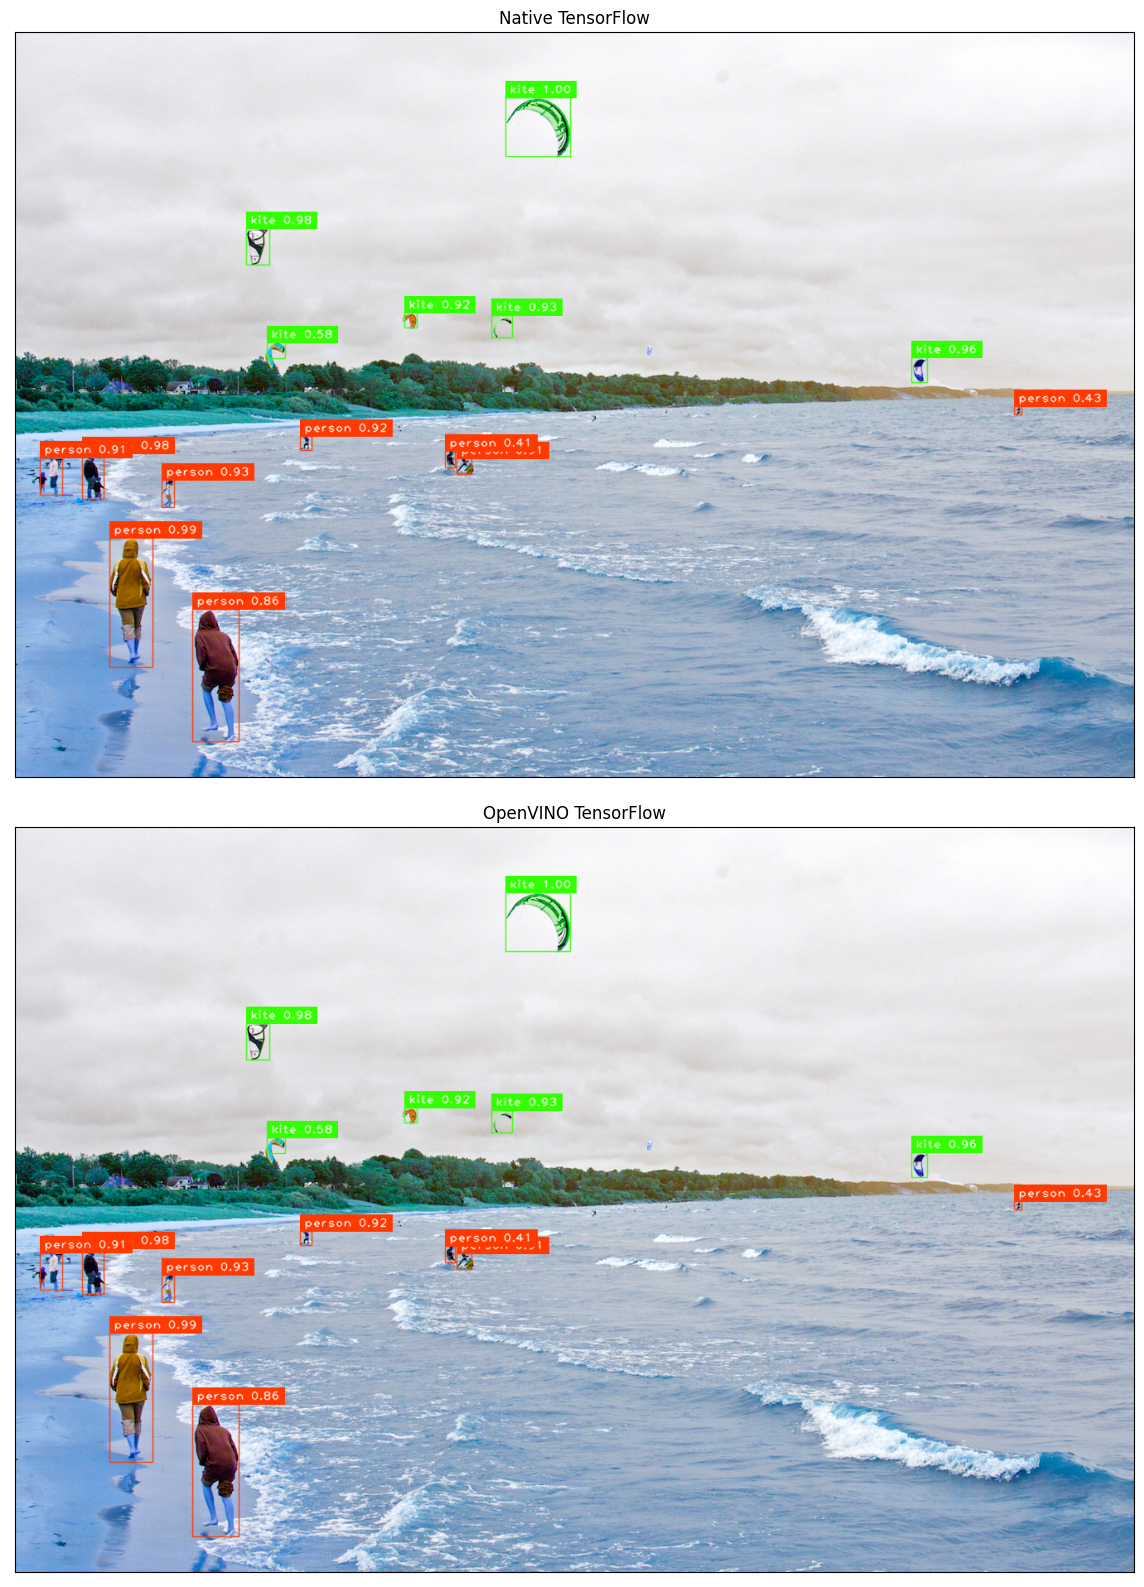

In [12]:
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

im_tf = cv2.imread("output_images/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8_TF_detected_output.png")
im_ovtf = cv2.imread("output_images/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8_OVTF_detected_output.png")

fig = plt.figure(figsize=(32, 20))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 share_all=True
                 )
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

grid[0].set_title("Native TensorFlow", fontdict=None, loc='center', color = "k")
grid[1].set_title("OpenVINO integration with TensorFlow", fontdict=None, loc='center', color = "k")

for ax, im in zip(grid, [im_tf, im_ovtf]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

# Let's plot the performance results

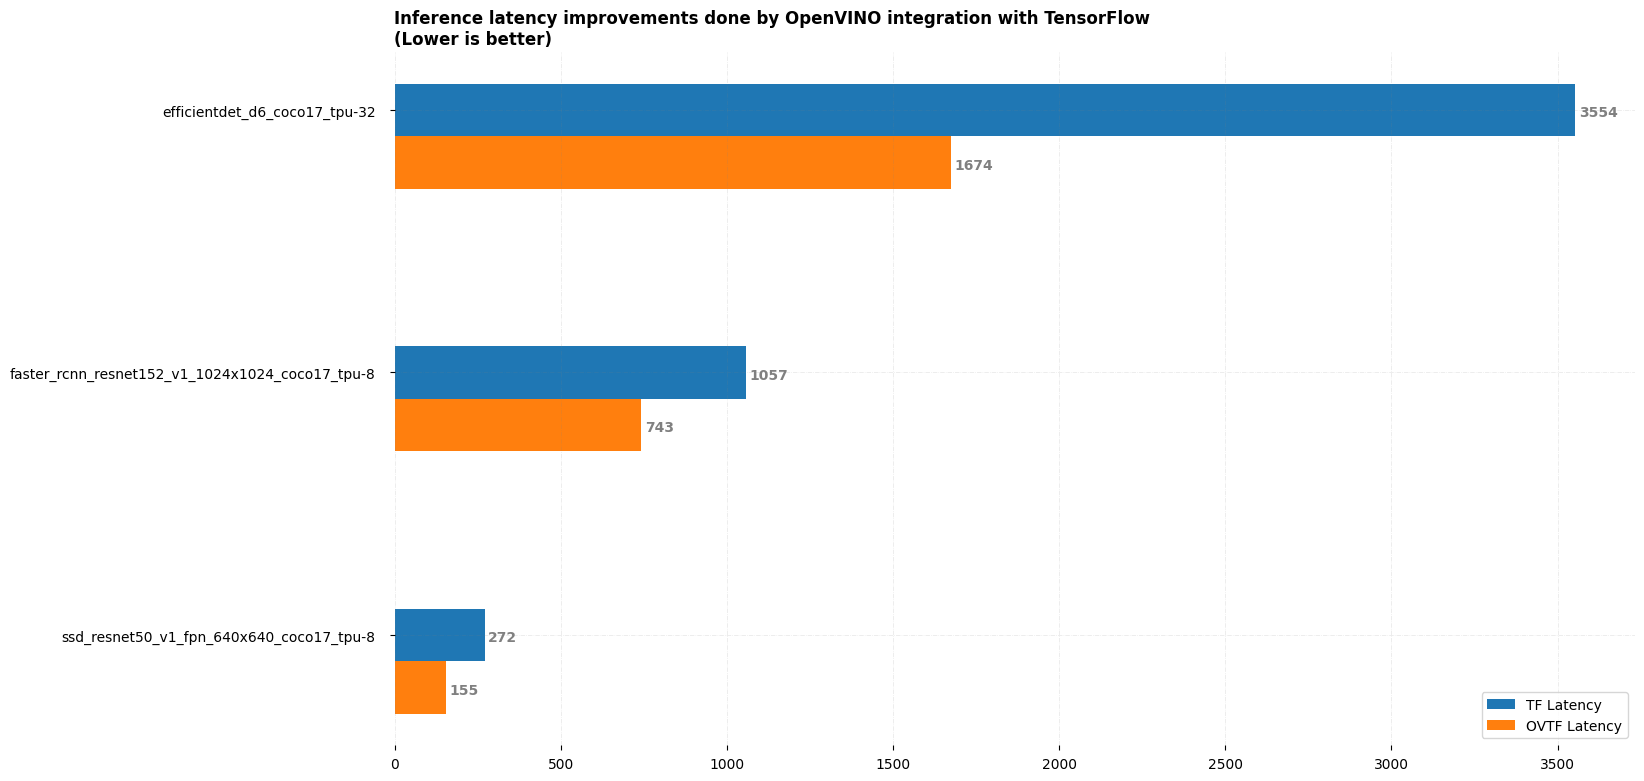

In [13]:
# Init a 16x9 plot
fig, ax = plt.subplots(figsize=(16, 9))

# Plot the values
Y = np.arange(len(ovtf_latency))
ax.barh(Y, list(tf_latency.values()), height=0.2)
ax.barh(Y+0.2, list(ovtf_latency.values()), height=0.2)

# Set Y-axis labels and add Legend
plt.yticks(Y, tf_latency.keys())
ax.legend(('TF Latency','OVTF Latency'))

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+10, i.get_y()+0.125,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Inference latency improvements done by OpenVINO integration with TensorFlow\n(Lower is better)', loc='left', fontweight='bold')

plt.show()